# [Reference](https://keras.io/examples/vision/mobilevit/)

# Introduction

In this example, we implement the MobileViT architecture (Mehta et al.), which combines the benefits of Transformers (Vaswani et al.) and convolutions. With Transformers, we can capture long-range dependencies that result in global representations. With convolutions, we can capture spatial relationships that model locality.

Besides combining the properties of Transformers and convolutions, the authors introduce MobileViT as a general-purpose mobile-friendly backbone for different image recognition tasks. Their findings suggest that, performance-wise, MobileViT is better than other models with the same or higher complexity (MobileNetV3, for example), while being efficient on mobile devices.

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image
import os, cv2, gc
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import callbacks
from tensorflow.keras import layers, losses, optimizers, metrics
import tensorflow_hub as hub
from keras.applications import imagenet_utils

#import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from keras.layers.advanced_activations import LeakyReLU

try:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass 

# enable mixed_precision and jit compiler 
tf.keras.mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)

In [ ]:
INP_SIZE      = (512, 512) # Input size of the Image Resizer Module (IRM)
TARGET_SIZE   = (224, 224) # Output size of IRM and Input size of the Vision Transformer 
INTERPOLATION = "bilinear"
N_CLASSES = 15587
#config_head = 'arcface'


NUM_FOLDS  = 5
BATCH_SIZE = 24
SEED       = 42

DATA_DIR  = '../input/happy-whale-and-dolphin/'
TRAIN_DIR = DATA_DIR + 'train_images/'
TEST_DIR  = DATA_DIR + 'test_images/'

# SetAutoTune
AUTOTUNE = tf.data.AUTOTUNE  

# Prepare tf.data object

In [ ]:
#https://www.kaggle.com/ipythonx/tf-keras-learning-to-resize-image-for-vit-model/notebook
def build_augmenter(is_labelled):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_saturation(img, 0.65, 1.05)
        img = tf.image.random_brightness(img, 0.05)
        img = tf.image.random_contrast(img, 0.75, 1.05)
        img = tf.image.random_hue(img, 0.05)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    return augment_with_labels if is_labelled else augment

def build_decoder(is_labelled, size):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        img = tf.image.decode_jpeg(file_bytes, channels = 3)
        img = tf.image.resize(img, (size[0], size[1]))
        return tf.cast(tf.divide(img, 255.),tf.float32)
    
    def decode_with_labels(path, label):
        label = tf.cast(label, tf.int32)
        return decode(path),label
    
    return decode_with_labels if is_labelled else decode

def create_dataset(df, 
                   batch_size  = 32, 
                   is_labelled = False, 
                   augment     = False, 
                   repeat      = False, 
                   shuffle     = False,
                   size        = INP_SIZE):
    decode_fn    = build_decoder(is_labelled, size)
    augmenter_fn = build_augmenter(is_labelled)
    
    # Create Dataset
    if is_labelled:
        dataset = tf.data.Dataset.from_tensor_slices((df['Id'].values, df['target_value'].values))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((df['Id'].values))
        
    dataset = dataset.map(decode_fn, num_parallel_calls = AUTOTUNE)
    dataset = dataset.map(augmenter_fn, num_parallel_calls = AUTOTUNE) if augment else dataset
    dataset = dataset.repeat() if repeat else dataset
    dataset = dataset.shuffle(1024, reshuffle_each_iteration = True) if shuffle else dataset
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
label_encoder = LabelEncoder()


In [ ]:
# Load Train Data
train_df = pd.read_csv(f'{DATA_DIR}train.csv')
train_df['Id'] = train_df['image'].apply(lambda x: f'{TRAIN_DIR}{x}')

# Adjust typos in "species" column from Andrada's kernel
train_df["species"] = train_df["species"].replace(["bottlenose_dolpin", "kiler_whale",
                                             "beluga", 
                                             "globis", "pilot_whale"],
                                            ["bottlenose_dolphin", "killer_whale",
                                             "beluga_whale", 
                                             "short_finned_pilot_whale", "short_finned_pilot_whale"])


# Set a specific label to be able to perform stratification
#train_df['stratify_label'] = train_df['individual_id']

train_df['target_value']  = label_encoder.fit_transform(train_df['individual_id'] )

# Summary
print(f'train_df: {train_df.shape}')
train_df.head()

In [ ]:
train_df[train_df['individual_id']=='19fbb960f07d']

In [ ]:
train_df.species.value_counts()

In [ ]:
train_df.isnull().sum()

In [ ]:
train_ds, val_ds = train_df[:30000], train_df[30000:]

In [ ]:
# Load Test Data
test_df = pd.read_csv(f'{DATA_DIR}sample_submission.csv')
test_df['Id'] = test_df['image'].apply(lambda x: f'{TEST_DIR}{x}')
test_df['individual_id'] = 0

# Summary
print(f'test_df: {test_df.shape}')
test_df.head()

# MobileViT

MobileViT architecture comprised of following blocks
* Strided 3x3 convolutions that process the input image
* MobileNetV2-style inverted residual blocks for downsampling the resolution of the intermediate feature maps
* MobileViT blocks that combine the benefits of Transformers and convolutions. It is presented in the figure below (taken from the original paper):

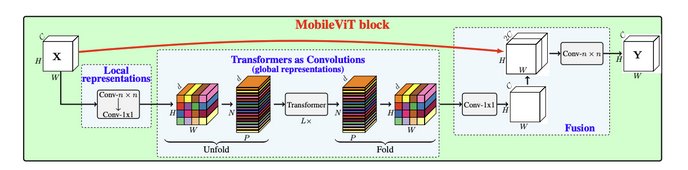

In [ ]:
# Values are from table 4.
patch_size = 4  # 2x2, for the Transformer blocks.
image_size = 256
expansion_factor = 2  # expansion factor for the MobileNetV2 blocks.

In [ ]:
def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv2D(
        filters, kernel_size, strides=strides, activation=tf.nn.swish, padding="same"
    )
    return conv_layer(x)


# Reference: https://git.io/JKgtC


def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = layers.Conv2D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    if strides == 2:
        m = layers.ZeroPadding2D(padding=imagenet_utils.correct_pad(m, 3))(m)
    m = layers.DepthwiseConv2D(
        3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False
    )(m)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    m = layers.Conv2D(output_channels, 1, padding="same", use_bias=False)(m)
    m = layers.BatchNormalization()(m)

    if tf.math.equal(x.shape[-1], output_channels) and strides == 1:
        return layers.Add()([m, x])
    return m


# Reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=[x.shape[-1] * 2, x.shape[-1]], dropout_rate=0.1,)
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x


def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with convolutions.
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(
        local_features, filters=projection_dim, kernel_size=1, strides=strides
    )

    # Unfold into patches and then pass through Transformers.
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / patch_size)
    non_overlapping_patches = layers.Reshape((patch_size, num_patches, projection_dim))(
        local_features
    )
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim
    )

    # Fold into conv-like feature-maps.
    folded_feature_map = layers.Reshape((*local_features.shape[1:-1], projection_dim))(
        global_features
    )

    # Apply point-wise conv -> concatenate with the input features.
    folded_feature_map = conv_block(
        folded_feature_map, filters=x.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features = layers.Concatenate(axis=-1)([x, folded_feature_map])

    # Fuse the local and global features using a convoluion layer.
    local_global_features = conv_block(
        local_global_features, filters=projection_dim, strides=strides
    )

    return local_global_features


# More on the MobileViT block:

*     First, the feature representations (A) go through convolution blocks that capture local relationships. The expected shape of a single entry here would be (h, w, num_channels).
*     Then they get unfolded into another vector with shape (p, n, num_channels), where p is the area of a small patch, and n is (h * w) / p. So, we end up with n non-overlapping patches.
*     This unfolded vector is then passed through a Tranformer block that captures global relationships between the patches.
*     The output vector (B) is again folded into a vector of shape (h, w, num_channels) resembling a feature map coming out of convolutions.

Vectors A and B are then passed through two more convolutional layers to fuse the local and global representations. Notice how the spatial resolution of the final vector remains unchanged at this point. The authors also present an explanation of how the MobileViT block resembles a convolution block of a CNN. For more details, please refer to the original paper.

Next, we combine these blocks together and implement the MobileViT architecture (XXS variant). The following figure (taken from the original paper) presents a schematic representation of the architecture:

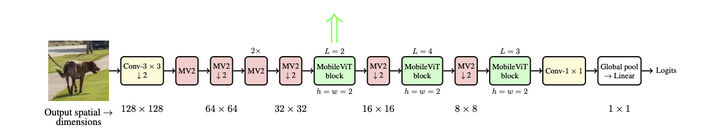

In [ ]:
def create_mobilevit(num_classes=N_CLASSES):
    inputs = keras.Input((image_size, image_size, 3))
    
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=16
    )

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2
    )
    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * expansion_factor, output_channels=64, strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)

    # Classification head.
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes,kernel_regularizer='l2', activation="softmax")(x)

    return keras.Model(inputs, outputs)


mobilevit_xxs = create_mobilevit()
#mobilevit_xxs.summary()

In [ ]:
mobilevit_xxs.summary()

In [ ]:
batch_size = 128
auto = tf.data.AUTOTUNE
resize_bigger = 280

In [ ]:
individual_id_group = train_df['target_value'].copy().to_list()

# Training , Valdation Dataset 

In [ ]:
trn_ds, val_ds = train_test_split(train_df,test_size=0.33, random_state=42) 

In [ ]:
#train_df =  train_df.sample(frac = 0.1)
trn_ds.shape, val_ds.shape

In [ ]:
training_dataset = create_dataset(trn_ds,
                                  batch_size  = BATCH_SIZE, 
                                  is_labelled = True, 
                                  augment = True,
                                  repeat  = False, 
                                  shuffle = False,
                                 size = (image_size, image_size))
#sample_train_images, _ = next(iter(training_dataset))

In [ ]:
batch, labels = next(iter(training_dataset))

In [ ]:
plt.figure(figsize=(16, 10))
for i, image in enumerate(batch[:20]):
    ax = plt.subplot(5, 4, i + 1)
    plt.title(labels[i].numpy())
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")


plt.tight_layout()

In [ ]:
val_dataset = create_dataset(val_ds,
                                  batch_size  = BATCH_SIZE, 
                                  is_labelled = True, 
                                  augment = True,
                                  repeat  = False, 
                                  shuffle = False,
                            size = (image_size, image_size))
#sample_val_images, _ = next(iter(val_dataset))

In [ ]:
batch, labels = next(iter(val_dataset))

In [ ]:
plt.figure(figsize=(16, 10))
for i, image in enumerate(batch[:20]):
    ax = plt.subplot(5, 4,  i + 1)
    plt.title(labels[i].numpy())
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")


plt.tight_layout()

# Train a MobileViT (XXS) model

In [ ]:
#unq_lbls = train_df.target_value.unique()

from sklearn.utils import class_weight
class_wgt = dict(zip(np.unique(train_df.target_value), class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(train_df.target_value), 
                y = train_df.target_value))) 
#class_wgt = class_weight.compute_class_weight(class_weight = 'balanced',classes = np.unique(train_df.target_value),y = train_df.target_value )

In [ ]:
learning_rate = 0.002
label_smoothing_factor = 0.1
epochs = 3

#optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate,decay=1e-6, momentum=0.9, clipnorm=1. )
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing_factor)
loss_fn = keras.losses.SparseCategoricalCrossentropy()


def run_experiment(model, fold, epochs=epochs):
    tf.keras.backend.clear_session()
    gc.collect()
    if fold < 1 :
        
        model.compile(optimizer=optimizer, 
                              loss=loss_fn,
                              #metrics = ['accuracy'])
                              metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)])

        checkpoint_filepath = "/tmp/checkpoint"
        checkpoint_callback = keras.callbacks.ModelCheckpoint(
            checkpoint_filepath,
            monitor="val_sparse_categorical_accuracy",
            save_best_only=True,
            save_weights_only=True,
        )


        trn = train_df.iloc[train_index]
        val = train_df.iloc[val_index]
        training_dataset = create_dataset(trn, 
                                          batch_size  = BATCH_SIZE, 
                                          is_labelled = True, 
                                          augment     = True, 
                                          repeat      = False, 
                                          shuffle     = False,
                                         size = (image_size, image_size))
        val_dataset = create_dataset(val, 
                                            batch_size  = BATCH_SIZE, 
                                            is_labelled = True,
                                            augment     = True, 
                                            repeat      = False,
                                            shuffle     = False,
                                           size = (image_size, image_size))


        history = model.fit(
            training_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            class_weight = class_wgt,
            callbacks=[checkpoint_callback],
        )
        #model.summary()
        model.load_weights(checkpoint_filepath)
        _,_, accuracy = model.evaluate(val_dataset)
        print(f"Validation accuracy: {round(accuracy * 100, 2)}%")
    



**We would like to see the images related to individual ids, so taken the samples base on  GroupKFold here.**

*[Please Refer here for more inforamtion on GroupKfold](https://www.kaggle.com/reighns/groupkfold-and-stratified-groupkfold-efficientnet)*

In [ ]:
from sklearn.model_selection import StratifiedKFold, GroupKFold

# OOF RMSE Placeholder

kfold = GroupKFold(n_splits = NUM_FOLDS)
for fold, (train_index, val_index) in enumerate(kfold.split(train_df.index, train_df['target_value'], groups=individual_id_group)):
    mobilevit_xxs = create_mobilevit(num_classes=N_CLASSES)    
    
    run_experiment(mobilevit_xxs, fold)    

In [ ]:
'''
plt.figure(figsize=(8,8), tight_layout=True)
plt.subplot(211)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(' Loss')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(212)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('SparseCategoricalAccuracy Metric')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
'''

In [ ]:
# Serialize the model as a SavedModel.
mobilevit_xxs.save("mobilevit_xxs")

# Inference

In [ ]:
test_dataset = create_dataset(test_df,
                                  batch_size  = BATCH_SIZE, 
                                  is_labelled = False, 
                                  augment = False,
                                  repeat  = False, 
                                  shuffle = False,
                            size = (image_size, image_size))
test_images = next(iter(test_dataset))


In [ ]:
plt.figure(figsize=(16, 10))
for i, image in enumerate(test_images[:20]):
    ax = plt.subplot(5, 4,  i + 1)
    #plt.title(" Image")
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

plt.tight_layout()


In [ ]:
#batch = next(iter(test_dataset))


In [ ]:
dict_ids =dict(zip( train_df['target_value'], train_df['individual_id']))

In [ ]:
test_preds = mobilevit_xxs.predict(test_dataset)

In [ ]:
#dict_ids.get(1104)

In [ ]:
'''
for i in range(2):
    arr = test_preds[i].argsort()[-top_n:][::-1]
    print (arr)
    r  = [''.join(dict_ids.get(arr[j])) for j in range(top_n)]
    print (r)
'''

In [ ]:
top_n = 5
for i in range(len(test_preds)):
    arr = test_preds[i].argsort()[-top_n:][::-1]
    #print (arr)
    test_df['predictions'][i]  = [''.join(dict_ids.get(arr[j])) for j in range(top_n)]
    #print (r)
    #test_df['predictions'][i] = r


In [ ]:
sub_df = test_df[['image', 'predictions']]

In [ ]:
sub_df.to_csv('submission.csv', index = False)

In [ ]:
!tail submission.csv

Provide your feedback to help me improve further. Thank you.